In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import torch.nn.functional as F
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import optuna
import torch.optim as Optim

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

C:\Users\user\anaconda3\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 8000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
tr = transforms.Compose([transforms.ToTensor(),])
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True, transform=tr)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True,transform=tr)

In [9]:
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
# train_dataset, val_dataset = random_split(Train_dataset, (50000, 10000))
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
# validation_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [10]:
class VAE(nn.Module):
    
    def __init__(self, encoded_space_dim=2,NumFL1=16,NumFL2=32,NumFL3=64,latent=65):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=NumFL1, kernel_size = 3,stride = 2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=NumFL1, out_channels=NumFL2, kernel_size = 3,stride = 2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=NumFL2, out_channels=NumFL3, kernel_size = 3,stride = 2, padding=0),
            nn.ReLU(True)
#             nn.Conv2d(in_channels=NumFL3, out_channels=NumFL3, kernel_size = 3,stride = 2, padding=0),
#             nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=3*3*NumFL3, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
#             nn.Linear(in_features=latent, out_features=encoded_space_dim)
        )
        ### variational part
        self.Mean = nn.Linear(in_features=latent,out_features=encoded_space_dim)
        self.LogSigma = nn.Linear(in_features=latent,out_features=encoded_space_dim)
        ### 
        
        
        #--------------------------------------------------------------------------------------
        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=latent, out_features=3*3*NumFL3),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(NumFL3, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL3, out_channels=NumFL2, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL2, out_channels=NumFL1, kernel_size=3,stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL1, out_channels=1, kernel_size=3,stride=2, padding=1, output_padding=1)
        )
    def distribution(self,mean,Logvariance):
            ebsilon = torch.randn_like(mean)# the same as torch.randn(mean.size[0],mean.size[1])
            return mean + ebsilon * torch.exp(Logvariance/2)
    def forward(self, x):
        x = self.encoder_cnn(x)# Apply convolutions
        x = self.flatten(x)# Flatten
        # # Apply linear layers
        x = self.encoder_lin(x)
        M = self.Mean(x)
        S = self.LogSigma(x)
        Z = self.distribution(M,S)
        # -----------------------------------------------
        #Apply linear layers
        x = self.decoder_lin(Z)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x,Z,M,S

In [11]:
encoded_space_dim = 3
bestParams = {'lr': 0.005, 'optimizer': 'Adam', 'NumF1': 16,
              'NumF2': 32, 'NumF3': 64, 'latent_layer': 94}
VAEmodel = VAE(encoded_space_dim=encoded_space_dim,NumFL1=int(bestParams['NumF1']),NumFL2=int(bestParams['NumF2']),
                   NumFL3=int(bestParams['NumF3']),latent=int(bestParams['latent_layer']))

In [12]:
lr = bestParams['lr'] # Learning rate
optim = torch.optim.Adam(VAEmodel.parameters(), lr=lr)

In [13]:
lossFunction = F.mse_loss

In [14]:
def KL_Loss(mean,LogVar):
    kl_div = -0.5 * torch.sum(1 + LogVar - mean**2  - torch.exp(LogVar), axis=1) # sum over latent dimension
    batchsize = kl_div.size(0)
    kl_div = kl_div.mean()
    return kl_div,batchsize

In [15]:
### Training function
def train_epoch_VAE(encoder, device, dataloader, loss_fn, optimizer,alpha):
    # Set train mode for both the encoder and the decoder
    encoder.train()
#     decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    batch_error = []
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)

        outImage,Z,mean,LogVar = encoder(image_batch)
        kl_loss,BatchSize = KL_Loss(mean,LogVar)
        loss = lossFunction(outImage, image_batch, reduction='none')
        loss = loss.view(BatchSize,-1).sum(axis = 1)
        loss = loss.mean()
        loss = alpha*loss + kl_loss
        batch_error.append(loss.item())
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return batch_error
        # Print batch loss
#         print('\t partial train loss (single batch): %f' % (loss.data))

In [16]:
### Testing function
def test_epochVAE(encoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    batchValError = []
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            outImage,_,_,_= encoder(image_batch)
            
            # Append the network output and the original image to the lists
            conc_out.append(outImage.cpu())
            conc_label.append(image_batch.cpu())
            batchValError.append(loss_fn(outImage,image_batch).item())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data,batchValError

In [17]:
### Training cycle
num_epochs = 20
alpha = 1
batchError = []
batchValError = []
validError = []
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    
    """" --------------- Training ---------------------"""
    temp = train_epoch_VAE(encoder = VAEmodel,device = device,dataloader = train_dataloader,loss_fn = lossFunction,optimizer = optim,alpha=alpha)
    for L in temp:
        batchError.append(L)
    ### Validation  (use the testing function)
    val_loss,batchvalerror = test_epochVAE(encoder=VAEmodel,device=device,dataloader=test_dataloader,
                          loss_fn=lossFunction)
    for L in batchvalerror:
        batchValError.append(L)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    VAEmodel.eval()
#     decoder.eval()
    with torch.no_grad():
        rec_img,_,_,_  = VAEmodel(img)
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(8,4))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(VAEmodel.state_dict(), 'encoder_params.pth')
#     torch.save(decoder.state_dict(), 'decoder_params.pth')

    # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training

EPOCH 1/20


KeyboardInterrupt: 

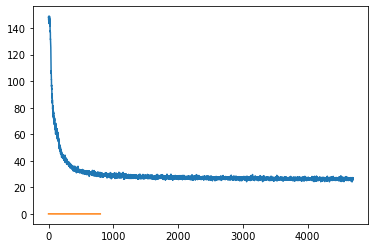

In [23]:
plt.plot(range(len(batchError)),(batchError))
plt.plot(range(len(batchValError)),(batchValError))


In [24]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    VAEmodel.eval()
    with torch.no_grad():
        _,encoded_img,_,_  = VAEmodel(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:12<00:00, 811.15it/s]


In [25]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  label
0           -1.053251         0.979733        -0.792393      9
1            0.136197        -2.264093        -0.153885      2
2            1.816350         0.962932        -1.526636      1
3            1.064971         1.417487        -0.664909      1
4           -0.139205        -0.574057        -0.769588      6
...               ...              ...              ...    ...
9995        -1.794491        -0.166790        -0.820733      9
9996         0.738912         1.502163         0.089857      1
9997         0.473817         0.274715         1.224535      8
9998         1.128980         1.658363         1.061025      1
9999        -0.535123         0.744951         0.291799      5

[10000 rows x 4 columns]

In [ ]:
import plotly.express as px

fig = px.scatter_3d(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', z='Enc. Variable 2',
              color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=1,size=10)
fig.show()

In [43]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)

In [44]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(train_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    VAEmodel.eval()
    with torch.no_grad():
        _,encoded_img,_,_  = VAEmodel(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)

100%|██████████| 60000/60000 [01:04<00:00, 929.03it/s] 


In [7]:
class VAE2(nn.Module):
    
    def __init__(self, encoded_space_dim=2,NumFL1=16,NumFL2=32,NumFL3=64,latent=65):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size = 3,stride = 1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=NumFL1, kernel_size = 3,stride = 2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=NumFL1, out_channels=NumFL2, kernel_size = 3,stride = 2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=NumFL2, out_channels=NumFL3, kernel_size = 3,stride = 2, padding=0),
            nn.ReLU(True)
#             nn.Conv2d(in_channels=NumFL3, out_channels=NumFL3, kernel_size = 3,stride = 2, padding=0),
#             nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=3*3*NumFL3, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
#             nn.Linear(in_features=latent, out_features=encoded_space_dim)
        )
        ### variational part
        self.Mean = nn.Linear(in_features=latent,out_features=encoded_space_dim)
        self.LogSigma = nn.Linear(in_features=latent,out_features=encoded_space_dim)
        ### 
        
        
        #--------------------------------------------------------------------------------------
        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=latent, out_features=3*3*NumFL3),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(NumFL3, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL3, out_channels=NumFL2, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL2, out_channels=NumFL1, kernel_size=3,stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL1, out_channels=16, kernel_size=3,stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3,stride=1, padding=1)
        )
    def distribution(self,mean,Logvariance):
            ebsilon = torch.randn_like(mean)# the same as torch.randn(mean.size[0],mean.size[1])
            return mean + ebsilon * torch.exp(Logvariance/2)
    def forward(self, x):
        x = self.encoder_cnn(x)# Apply convolutions
        x = self.flatten(x)# Flatten
        # # Apply linear layers
        x = self.encoder_lin(x)
        M = self.Mean(x)
        S = self.LogSigma(x)
        Z = self.distribution(M,S)
        # -----------------------------------------------
        #Apply linear layers
        x = self.decoder_lin(Z)
        x = self.unflatten(x)# Unflatten
        x = self.decoder_conv(x)# Apply transposed convolutions
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x,Z,M,S

In [8]:
VAEmodel2 = VAE2()

In [9]:
lr = 5e-4 # Learning rate
optim = torch.optim.Adam(VAEmodel2.parameters(), lr=lr, weight_decay=1e-5)

In [14]:
### Training cycle
num_epochs = 20
alpha = 1
batchError2 = []
batchValError2 = []
validError2 = []
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    
    """" --------------- Training ---------------------"""
    temp = train_epoch_VAE(encoder = VAEmodel2,device = device,dataloader = train_dataloader,loss_fn = lossFunction,optimizer = optim,alpha=alpha)
    for L in temp:
        batchError2.append(L)
    ### Validation  (use the testing function)
    val_loss,batchvalerror = test_epochVAE(encoder=VAEmodel2,device=device,dataloader=test_dataloader,
                          loss_fn=lossFunction)
    for L in batchvalerror:
        batchValError2.append(L)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    VAEmodel2.eval()
#     decoder.eval()
    with torch.no_grad():
        rec_img,_,_,_  = VAEmodel2(img)
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(8,4))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(VAEmodel2.state_dict(), 'encoder_params2.pth')
#     torch.save(decoder.state_dict(), 'decoder_params.pth')

    # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training

EPOCH 1/20


NameError: name 'lossFunction' is not defined

In [ ]:
plt.plot(range(len(batchError2)),(batchError2))
plt.plot(range(len(batchValError2)),(batchValError2))
